# Classification using random and Nyström features.

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the use of random and Nystöm features with linear SVMs to carry out non-linear classification.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import kernel_approximation as ka
import pandas as pd
from sklearn import svm
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.kernel_approximation import RBFSampler
from sklearn import datasets
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import NuSVC
from kernel_approximation import RandomFeaturesSamplerRBF
from sklearn.pipeline import Pipeline

In [2]:
"""
# A simple 2 D problem
np.random.seed(0)
n_samples = 300
X = np.random.randn(n_samples, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
"""
# A not so simple 2 D problem
noise = 0.3

# Training set 
X, y = datasets.make_moons(n_samples=100, noise=noise, random_state=0)

# Test set 
X_test, y_test = datasets.make_moons(n_samples=1000, noise=noise)

# Compute grid of points for plotting the decision regions

grid_x1, grid_x2 = np.meshgrid(
    np.linspace(-3, 3, 50),
    np.linspace(-3, 3, 50),
)

grid_X = np.c_[grid_x1.ravel(), grid_x2.ravel()]

# Plot the decision regions 
def plot_decision_regions(X, y, grid_x1, grid_x2, features_grid, clf):

    # plot the decision function for each datapoint on the grid
    Z = clf.decision_function(features_grid)
    Z = Z.reshape(grid_x1.shape)


    plt.imshow(Z, interpolation='nearest',
    extent=(grid_x1.min(), grid_x1.max(), grid_x2.min(), grid_x2.max()), aspect='auto',
    origin='lower', cmap=plt.cm.PuOr_r)

    contours = plt.contour(grid_x1, grid_x2, Z, levels=[0], linewidths=2,
    linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,
    edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis([np.min(grid_x1), np.max(grid_x1), np.min(grid_x2), np.max(grid_x2)])
    plt.show()

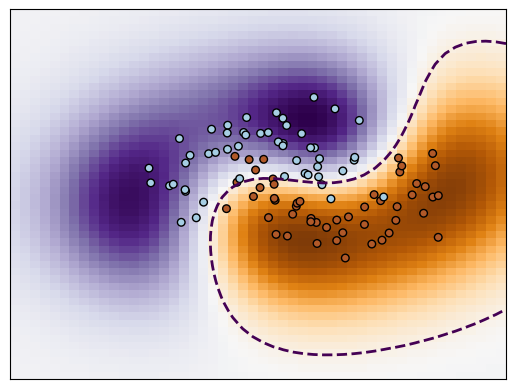

In [3]:
# Nonlinear SVM 

gamma = 0.5
sigma = np.sqrt(1.0 / 2.0 / gamma)

clf = svm.SVC(kernel='rbf', gamma=gamma)
# clf = svm.NuSVC(gamma=gamma)

clf.fit(X, y)

plot_decision_regions(X, y, grid_x1, grid_x2, grid_X, clf)

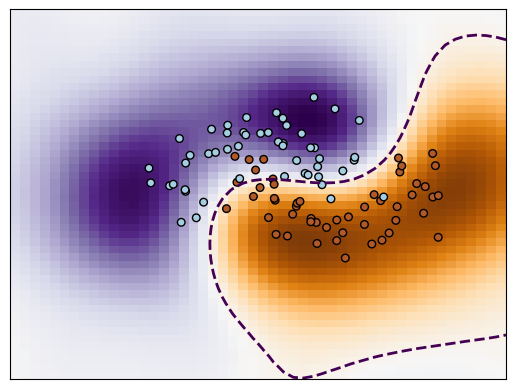

In [4]:
# RBF Fourier random features (sklearn)

n_random_features = 10000

rbf_sampler = RBFSampler(gamma=gamma, n_components=n_random_features, random_state=1)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.fit_transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')

clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

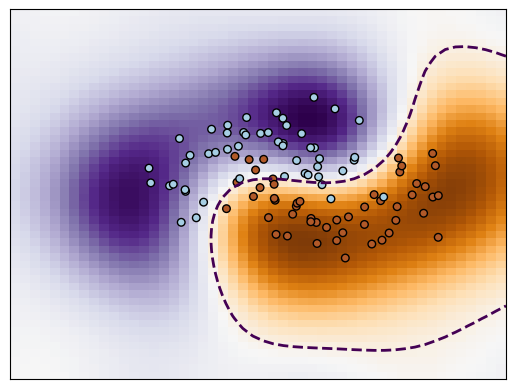

In [5]:
# RBF Fourier random features (our implementation)

rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma)
random_features = rbf_sampler.fit_transform(n_random_features, X)
random_features_grid = rbf_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')
clf.fit(random_features, y)


plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

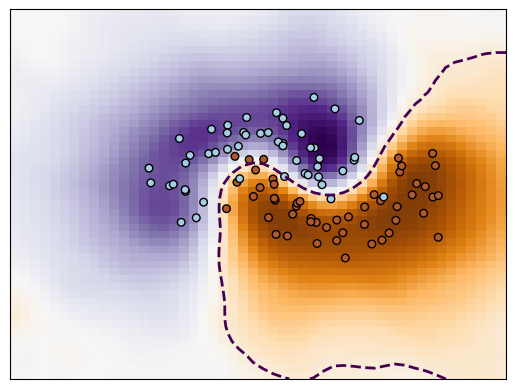

In [6]:
# Matérn Fourier random features (our implementation)
length_scale = sigma
nu = 1.5

matern_sampler = ka.RandomFeaturesSamplerMatern(length_scale, nu)    
random_features = matern_sampler.fit_transform(n_random_features, X)
random_features_grid = matern_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

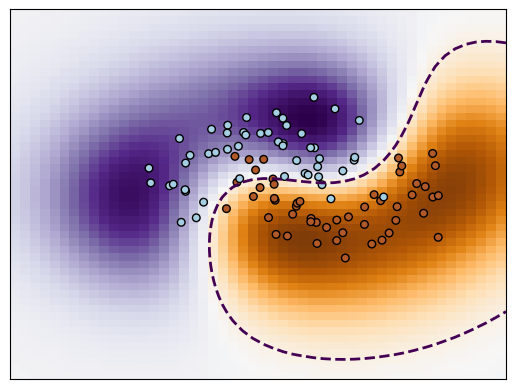

In [7]:
# Nystroem features (our implementation)

# Kernel matrix
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 

n_nystroem_features = 20
# n_nystroem_features = len(X) # Recovers full kernel

nystroem_sampler = ka.NystroemFeaturesSampler(kernel)
nystroem_features = nystroem_sampler.fit_transform(n_nystroem_features, X)
nystroem_features_grid = nystroem_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(nystroem_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, nystroem_features_grid, clf)

## Exercises

1. Afer having scaled the data to the range $[-1, 1]$ using sklearn's *MinMaxScaler*, determine the optimal hyperparameters (gamma, nu) and the optimal number of features for the different classifiers consideres in this example using CV on the training set. Compare the prediction error of the different classifiers in the test set $\left\{X_{test}, y_{test} \right\}$. 

References:
https://scikit-learn.org/stable/modules/preprocessing.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py



### Data generation and scaling

In [8]:
# A not so simple 2 D problem
noise = 0.3

# Training set 
X, y = datasets.make_moons(n_samples=100, noise=noise, random_state=0)

# Test set 
X_test, y_test = datasets.make_moons(n_samples=1000, noise=noise)

# Scale to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

### Evaluation Function

Now we will define a function to evaluate the performance of the different classifiers. Also, a function called `compare_models` will be defined to compare the performance of the different classifiers.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Assuming X_train_scaled, X_test_scaled, y, and y_test are defined somewhere in the notebook

def evaluate_model(clf, param_grid, model_name):
    """
    Evaluates a machine learning model using GridSearchCV and generates performance metrics.
    
    Parameters:
    -----------
    clf : estimator object
        A scikit-learn estimator that implements fit and predict methods
    param_grid : dict
        Dictionary with parameters names (string) as keys and lists of parameter 
        settings to try as values for GridSearchCV
    model_name : str
        Identifier name for the model being evaluated
        
    Returns:
    --------
    dict
        Dictionary containing:
        - model_name: Name of the model
        - best_params: Best parameters found by GridSearchCV
        - cv_score: Mean cross-validation score
        - test_score: Score on test set
        - weighted_precision: Weighted average precision
        - weighted_recall: Weighted average recall
        - weighted_f1: Weighted average F1 score
        - class_metrics: Per-class performance metrics
    """
    grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y)

    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test_scaled)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    result = {
        'model_name': model_name,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'test_score': best_clf.score(X_test_scaled, y_test),
        'weighted_precision': report['weighted avg']['precision'],
        'weighted_recall': report['weighted avg']['recall'],
        'weighted_f1': report['weighted avg']['f1-score'],
        'class_metrics': {}
    }
    
    for class_label in sorted(set(y_test)):
        result['class_metrics'][f'class_{class_label}'] = {
            'precision': report[str(class_label)]['precision'],
            'recall': report[str(class_label)]['recall'],
            'f1_score': report[str(class_label)]['f1-score']
        }

    return result

def compare_models(models_config):
    """Compare multiple models and create comparison tables."""
    all_results = []
    
    # Evaluate each model
    for config in models_config:
        result = evaluate_model(
            config['estimator'],
            config['params'],
            config['name']
        )
        all_results.append(result)
    
    # Create metrics DataFrames
    overall_metrics = pd.DataFrame([
        {
            'Model': r['model_name'],
            'CV Score': r['cv_score'],
            'Test Score': r['test_score'],
            'Weighted Precision': r['weighted_precision'],
            'Weighted Recall': r['weighted_recall'],
            'Weighted F1': r['weighted_f1']
        }
        for r in all_results
    ]).set_index('Model')
    
    class_metrics = pd.DataFrame([
        {
            'Model': result['model_name'],
            'Class': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-score': metrics['f1_score']
        }
        for result in all_results
        for class_name, metrics in result['class_metrics'].items()
    ])
    
    return overall_metrics.round(4), class_metrics.round(4), all_results

def display_optimal_parameters(all_results):
    """Display formatted table of optimal parameters."""
    params_data = []
    
    for result in all_results:
        params_data.append({
            'Model': result['model_name'],
            'Best Parameters': result['best_params'],
            'CV Score': f"{result['cv_score']:.4f}"
        })
    
    df = pd.DataFrame(params_data)
    styled_df = df.style\
        .set_caption("Optimal Parameters by Model")\
        .set_properties(**{
            'text-align': 'left',
            'padding': '10px',
            'border': '1px solid black'
        })\
        .set_table_styles([
            {'selector': 'caption',
             'props': [('font-size', '14pt'),
                      ('font-weight', 'bold')]},
            {'selector': 'th',
             'props': [('background-color', '#f2f2f2'),
                      ('font-weight', 'bold')]}
        ])\
        .hide(axis='index')
    
    display(styled_df)

In [10]:
# Custom classes for our samplers to be used with scikit-learn's Pipeline
class CustomRBFSampler:
    def __init__(self, sigma=1, n_random_features=1000):
        self.sigma = sigma
        self.n_random_features = n_random_features
        self.sampler = None

    def fit(self, X, y=None):
        self.sampler = RandomFeaturesSamplerRBF(self.sigma)
        self.sampler.fit_transform(self.n_random_features, X)
        return self

    def transform(self, X):
        return self.sampler.transform(X)

    def set_params(self, **parameters):
        """Sets the parameters of this estimator."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
class CustomMaternSampler:
    def __init__(self, length_scale=1.0, nu=1.5, n_random_features=1000):
        self.length_scale = length_scale
        self.nu = nu
        self.n_random_features = n_random_features
        self.sampler = None

    def fit(self, X, y=None):
        self.sampler = ka.RandomFeaturesSamplerMatern(self.length_scale, self.nu)
        self.sampler.fit_transform(self.n_random_features, X)
        return self

    def transform(self, X):
        return self.sampler.transform(X)

    def set_params(self, **parameters):
        """Sets the parameters of this estimator."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
class CustomNystroemSampler:
    def __init__(self, gamma = 1.0, n_nystroem_features=20):
        self.gamma = gamma
        self.n_nystroem_features = n_nystroem_features
        self.sampler = None

    def kernel(self, X, Y):
        return rbf_kernel(X, Y, gamma = self.gamma)
    
    def fit(self, X, y=None):
        self.sampler = ka.NystroemFeaturesSampler(self.kernel)
        self.sampler.fit_transform(self.n_nystroem_features, X)
        return self

    def transform(self, X):
        return self.sampler.transform(X)

    def set_params(self, **parameters):
        """Sets the parameters of this estimator."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [11]:
# Define model configurations
models_config = [
    # 1. SVM with RBF kernel
    {
        'estimator': NuSVC(kernel='rbf'),
        'params': {
            'gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            'nu': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
        },
        'name': 'SVM-RBF'
    },
    
    # 2. RBF Fourier features (sklearn)
    {
        'estimator': Pipeline([
            ('sampler', RBFSampler(random_state=1)),
            ('clf', NuSVC(kernel='linear'))
        ]),
        'params': {
            'sampler__gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            'sampler__n_components': [50, 100, 500, 1000, 5000, 10000],
            'clf__nu': [0.1, 0.3, 0.5]
        },
        'name': 'RBF-Fourier-SKLearn'
    },
    
    # 3. Our RBF Fourier features
    {
        'estimator': Pipeline([
            ('sampler', CustomRBFSampler()),
            ('clf', NuSVC(kernel='linear'))
        ]),
        'params': {
            'sampler__sigma': [0.050, 0.075 ,0.1, 0.25, 0.50, 0.75, 1.0, 1.5],
            'sampler__n_components': [50, 100, 500, 1000, 5000, 10000],
            'clf__nu': [0.05, 0.075, 0.1, 0.25, 0.5]
        },
        'name': 'RBF-Fourier-Custom'
    },
    
    # 4. Matérn Fourier features
    {
        'estimator': Pipeline([
            ('sampler', CustomMaternSampler()),
            ('clf', NuSVC(kernel='linear'))
        ]),
        'params': {
            'sampler__length_scale': [0.05, 0.1, 0.5, 1.0, 1.5, 2.0],
            'sampler__nu': [0.01, 0.05, 0.1, 0.5, 1.0],
            'clf__nu': [0.05, 0.075, 0.1, 0.25, 0.5, 0.7, 1.0]
        },
        'name': 'Matern-Fourier'
    },
    
    # 5. Nyström features
    {
        'estimator': Pipeline([
            ('sampler', CustomNystroemSampler()
            ),
            ('clf', NuSVC(kernel='linear'))
        ]),
        'params': {
            'sampler__gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            'sampler__n_components': [500, 1000, 5000, 10000],
            'clf__nu': [0.03, 0.05, 0.1, 0.3, 0.5]
        },
        'name': 'Nystroem'
    }
]

# Use configurations with compare_models function
overall_metrics, class_metrics, all_results = compare_models(models_config)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


c:\Users\imcir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
54 fits failed out of a total of 126.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\imcir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\imcir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\imcir\AppData\Local\Programs\Python\Python310\lib\site-package

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 240 candidates, totalling 720 fits
Fitting 3 folds for each of 210 candidates, totalling 630 fits


c:\Users\imcir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
119 fits failed out of a total of 630.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\imcir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\imcir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\imcir\AppData\Local\Programs\Python\Python310\lib\site-packa

Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [12]:
# Display overall metrics
print("Overall Metrics:")
display(overall_metrics)

# Display class metrics
print("Class Metrics:")
display(class_metrics)

display_optimal_parameters(all_results)

Overall Metrics:


,CV Score,Test Score,Weighted Precision,Weighted Recall,Weighted F1
Model,,,,,
SVM-RBF,0.9498,0.898,0.8982,0.898,0.8980
RBF-Fourier-SKLearn,0.9498,0.888,0.8891,0.888,0.8879
RBF-Fourier-Custom,0.9501,0.851,0.8520,0.851,0.8509
Matern-Fourier,0.9599,0.888,0.8882,0.888,0.8880
Nystroem,0.9599,0.864,0.8661,0.864,0.8638


Class Metrics:


,Model,Class,Precision,Recall,F1-score
0,SVM-RBF,class_0,0.9061,0.888,0.8970
1,SVM-RBF,class_1,0.8902,0.908,0.8990
2,RBF-Fourier-SKLearn,class_0,0.9093,0.862,0.8850
3,RBF-Fourier-SKLearn,class_1,0.8688,0.914,0.8908
4,RBF-Fourier-Custom,class_0,0.8710,0.824,0.8469
5,RBF-Fourier-Custom,class_1,0.8330,0.878,0.8549
6,Matern-Fourier,class_0,0.8959,0.878,0.8869
7,Matern-Fourier,class_1,0.8804,0.898,0.8891
8,Nystroem,class_0,0.8383,0.902,0.8690
9,Nystroem,class_1,0.8939,0.826,0.8586


Model,Best Parameters,CV Score
SVM-RBF,"{'gamma': 10.0, 'nu': 0.25}",0.9498
RBF-Fourier-SKLearn,"{'clf__nu': 0.3, 'sampler__gamma': 10.0, 'sampler__n_components': 100}",0.9498
RBF-Fourier-Custom,"{'clf__nu': 0.25, 'sampler__n_components': 5000, 'sampler__sigma': 0.1}",0.9501
Matern-Fourier,"{'clf__nu': 0.1, 'sampler__length_scale': 0.5, 'sampler__nu': 0.5}",0.9599
Nystroem,"{'clf__nu': 0.3, 'sampler__gamma': 10.0, 'sampler__n_components': 500}",0.9599


As it can be seen, the values of the optimal parameters per model are inside the value intervals of the parameters (they are not a boundary value) which means that the results are indeed optimal.

Even with a random Fourier approximation, the performance of the model is similar to the standar SVM-RBF (for both the sklearn model and our model). However, our model needs more components to reach the optimal model which suggests that the implementation requiers more features for a similar performance, which decreases impretability.

It is reasonable to see that the Matern-Fourier model and the Nyströem model reach the best performances as for the plots above we can see that it is the best in capturing the data structure. The Nyströem improved the results of the RBF-based methods altough it needs a big number of components, which may suggest that a less interpretable mapping helped to improve the RBF-based models but not significantly.